In [5]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    SegformerForImageClassification,
    SegformerImageProcessor,
)
from datasets import load_dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm import tqdm
import cv2

ModuleNotFoundError: No module named '_lzma'

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using MPS device.")
else:
    device = torch.device("cpu")
    print("MPS is not available. Using CPU device.")

MPS is available. Using MPS device.


In [3]:
label_df = pd.read_csv('Filtered_Data_Entry_DS541.csv')

In [4]:
label_df = label_df.rename(columns={'Unnamed: 0': 'full_index'})

In [5]:
label_df.head(10)

,full_index,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,...,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding,subj_id
0,46,00000013_046.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
1,107,00000032_060.png,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32
2,108,00000072_000.png,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72
3,112,00000092_003.png,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,92
4,153,00000116_040.png,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,116
5,163,00000149_009.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,149
6,169,00000150_005.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,150
7,235,00000181_065.png,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,181
8,255,00000193_019.png,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,193
9,299,00000211_043.png,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,211


In [6]:
label_df.shape

(30805, 23)

In [7]:
num_labels_per_row = label_df[label_df.columns.drop(['full_index', 'id', 'subj_id'])].sum(axis=1)

In [8]:
num_labels_per_row

0        1
1        2
2        1
3        1
4        2
        ..
30800    1
30801    1
30802    1
30803    1
30804    1
Length: 30805, dtype: int64

In [9]:
avg_num_labels_per_row = np.mean(num_labels_per_row.values[:-1])  # Exclude No Finding

In [10]:
avg_num_labels_per_row

1.1515387611998442

In [11]:
image_info_df = pd.read_csv('Data_Entry_2017_v2020.csv')

In [12]:
image_info_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [13]:
all_file_names = []
with open('all_list.txt', 'r') as txtfile:
    for line in txtfile:
        all_file_names.append(line.strip())

In [14]:
all_file_names[:5]

['00000001_002.png',
 '00000002_000.png',
 '00000003_007.png',
 '00000004_000.png',
 '00000005_007.png']

In [15]:
train_val_files = os.listdir('train_val_images')

In [16]:
test_files = os.listdir('test_images')

In [17]:
test_image = test_files[0]

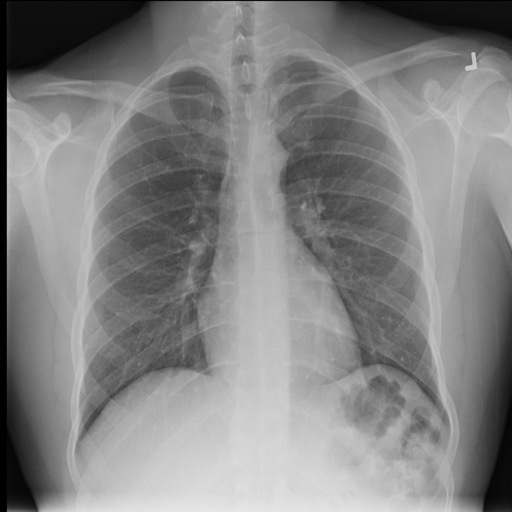

In [18]:
Image.open(os.path.join('test_images', test_image)).resize((512, 512))

In [19]:
labels = label_df.columns.drop(['full_index', 'id', 'subj_id'])

In [20]:
label_map = {label: i for i, label in enumerate(labels)}

In [21]:
label_map

{'Atelectasis': 0,
 'Cardiomegaly': 1,
 'Consolidation': 2,
 'Edema': 3,
 'Effusion': 4,
 'Emphysema': 5,
 'Fibrosis': 6,
 'Hernia': 7,
 'Infiltration': 8,
 'Mass': 9,
 'Nodule': 10,
 'Pleural Thickening': 11,
 'Pneumonia': 12,
 'Pneumothorax': 13,
 'Pneumoperitoneum': 14,
 'Pneumomediastinum': 15,
 'Subcutaneous Emphysema': 16,
 'Tortuous Aorta': 17,
 'Calcification of the Aorta': 18,
 'No Finding': 19}

In [22]:
train_val_df = label_df[label_df['id'].isin(train_val_files)][label_df.columns.drop(['full_index', 'subj_id'])]

In [23]:
train_val_df.head()

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Nodule,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding
2307,00000001_002.png,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2308,00000002_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2309,00000004_000.png,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2310,00000005_007.png,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2311,00000006_000.png,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [24]:
train_val_df.shape

(28008, 21)

In [25]:
train_val_image_paths = [os.path.join('train_val_images', file) for file in train_val_df.loc[:, 'id'].values]

In [26]:
train_val_labels = train_val_df.iloc[:, 1:].values

In [27]:
train_image_paths, val_image_paths, train_labels, val_labels = train_test_split(
    train_val_image_paths, train_val_labels, test_size=0.2, random_state=42
)

In [28]:
test_df = label_df[label_df['id'].isin(test_files)][label_df.columns.drop(['full_index', 'subj_id'])]

In [29]:
test_df.head()

,id,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,...,Nodule,Pleural Thickening,Pneumonia,Pneumothorax,Pneumoperitoneum,Pneumomediastinum,Subcutaneous Emphysema,Tortuous Aorta,Calcification of the Aorta,No Finding
0,00000013_046.png,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,00000032_060.png,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,00000072_000.png,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,00000092_003.png,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,00000116_040.png,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
test_df.shape

(2797, 21)

In [31]:
test_image_paths = [os.path.join('test_images', file) for file in test_df.loc[:, 'id'].values]

In [32]:
test_labels = test_df.iloc[:, 1:].values

In [33]:
def convert_to_rgb(image_path, size=512):
    image = Image.open(image_path).convert("RGB")
    if size:
        image = image.resize((size, size))
    return image

In [34]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, labels, image_processor, size=512):
        self.image_paths = image_paths
        self.labels = labels  # Multi-label format: list of lists or arrays
        self.image_processor = image_processor
        self.size = size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Convert the image to RGB and resize
        image = convert_to_rgb(self.image_paths[idx], size=self.size)
        
        # Convert the image to the format expected by the image processor
        inputs = self.image_processor(images=image, return_tensors="pt")
        
        # Get the label (convert to a multi-label binary vector if not already)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        
        return {**inputs, "labels": label}

In [35]:
image_processor = SegformerImageProcessor(do_resize=True, size=512)

In [36]:
train_dataset = ImageDataset(
    image_paths=train_image_paths,
    labels=train_labels,
    image_processor=image_processor
)

In [37]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [38]:
val_dataset = ImageDataset(
    image_paths=val_image_paths,
    labels=val_labels,
    image_processor=image_processor
)

In [39]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [40]:
test_dataset = ImageDataset(
    image_paths=test_image_paths,
    labels=test_labels,
    image_processor=image_processor
)

In [41]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [42]:
num_classes = len(labels)

In [3]:
model = SegformerForImageClassification.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=20,
)

Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
print(model)

SegformerForImageClassification(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
   

In [44]:
loss_fn = nn.BCEWithLogitsLoss()

In [45]:
optimizer = AdamW(model.parameters(), lr=5e-5)

In [46]:
def evaluate_model(model, val_loader, loss_fn):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # No gradient computation for validation
        for batch in val_loader:
            inputs = batch["pixel_values"].squeeze(1)  # Shape: (batch_size, 3, H, W)
            labels = batch["labels"]  # Shape: (batch_size, num_classes)

            # Forward pass
            outputs = model(pixel_values=inputs)
            logits = outputs.logits  # Shape: (batch_size, num_classes)

            # Compute loss
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            # For multi-label classification, calculate accuracy
            preds = (torch.sigmoid(logits) > 0.5).int()
            correct_predictions += (preds == labels).all(dim=1).sum().item()
            total_samples += labels.size(0)

    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples
    return avg_loss, accuracy

In [47]:
best_val_loss = float('inf')  # Track the best validation loss

for epoch in range(10):  # Number of epochs
    model.train()  # Set model to training mode
    total_train_loss = 0.0

    for batch in train_loader:
        inputs = batch["pixel_values"].squeeze(1)  # Shape: (batch_size, 3, H, W)
        labels = batch["labels"]  # Shape: (batch_size, num_classes)

        # Forward pass
        outputs = model(pixel_values=inputs)
        logits = outputs.logits  # Shape: (batch_size, num_classes)

        # Compute loss
        loss = loss_fn(logits, labels)
        total_train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute average training loss
    avg_train_loss = total_train_loss / len(train_loader)

    # Evaluate on validation set
    val_loss, val_accuracy = evaluate_model(model, val_loader, loss_fn)

    # Save the best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")

    print(
        f"Epoch {epoch + 1}: "
        f"Train Loss = {avg_train_loss:.4f}, "
        f"Val Loss = {val_loss:.4f}, "
        f"Val Accuracy = {val_accuracy:.4f}"
    )

Epoch 1: Train Loss = 0.1311, Val Loss = 0.1223, Val Accuracy = 0.5950
Epoch 2: Train Loss = 0.1189, Val Loss = 0.1205, Val Accuracy = 0.6119
Epoch 3: Train Loss = 0.1152, Val Loss = 0.1157, Val Accuracy = 0.5860
Epoch 4: Train Loss = 0.1119, Val Loss = 0.1148, Val Accuracy = 0.5735
Epoch 5: Train Loss = 0.1091, Val Loss = 0.1130, Val Accuracy = 0.5882
Epoch 6: Train Loss = 0.1056, Val Loss = 0.1147, Val Accuracy = 0.5646
Epoch 7: Train Loss = 0.1018, Val Loss = 0.1170, Val Accuracy = 0.5932
Epoch 8: Train Loss = 0.0971, Val Loss = 0.1161, Val Accuracy = 0.5441
Epoch 9: Train Loss = 0.0914, Val Loss = 0.1231, Val Accuracy = 0.5136
Epoch 10: Train Loss = 0.0853, Val Loss = 0.1243, Val Accuracy = 0.5102


In [53]:
model.load_state_dict(torch.load("best_model.pth", weights_only=True))
model.eval()

# Initialize variables to store predictions and true labels
all_predictions = []
all_true_labels = []

# No gradient computation during evaluation
with torch.no_grad():
    for batch in test_loader:  # Iterate through the test DataLoader
        # Extract inputs and labels from the batch
        inputs = batch["pixel_values"].squeeze(1)  # Shape: (batch_size, 3, H, W)
        labels = batch["labels"]  # Shape: (batch_size, num_classes)

        # Forward pass through the model
        outputs = model(pixel_values=inputs)
        logits = outputs.logits  # Shape: (batch_size, num_classes)

        # Apply a threshold to logits to generate binary predictions
        predictions = (torch.sigmoid(logits) > 0.5).int()

        # Collect predictions and true labels
        all_predictions.append(predictions.cpu())
        all_true_labels.append(labels.cpu())

# Concatenate all batches
all_predictions = torch.cat(all_predictions, dim=0).numpy()
all_true_labels = torch.cat(all_true_labels, dim=0).numpy()

# Compute and display classification metrics
print(classification_report(all_true_labels, all_predictions, target_names=label_map.keys()))

                            precision    recall  f1-score   support

               Atelectasis       0.63      0.10      0.17       191
              Cardiomegaly       1.00      0.02      0.04       101
             Consolidation       0.00      0.00      0.00        73
                     Edema       0.00      0.00      0.00        52
                  Effusion       0.61      0.24      0.34       242
                 Emphysema       0.00      0.00      0.00        41
                  Fibrosis       0.00      0.00      0.00        66
                    Hernia       0.00      0.00      0.00        17
              Infiltration       0.40      0.01      0.01       266
                      Mass       0.40      0.02      0.03       122
                    Nodule       0.67      0.02      0.03       120
        Pleural Thickening       0.00      0.00      0.00       107
                 Pneumonia       0.00      0.00      0.00        39
              Pneumothorax       0.00      0.00

/opt/anaconda3/envs/segformer_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/segformer_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [72]:
print("Unique classes in true labels:", np.unique(all_true_labels.argmax(axis=1)))
print("Unique classes in predictions:", np.unique(all_predictions.argmax(axis=1)))

Unique classes in true labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19]
Unique classes in predictions: [ 0  1  4  8  9 10 19]


In [54]:
cm = confusion_matrix(all_true_labels.argmax(axis=1), all_predictions.argmax(axis=1))

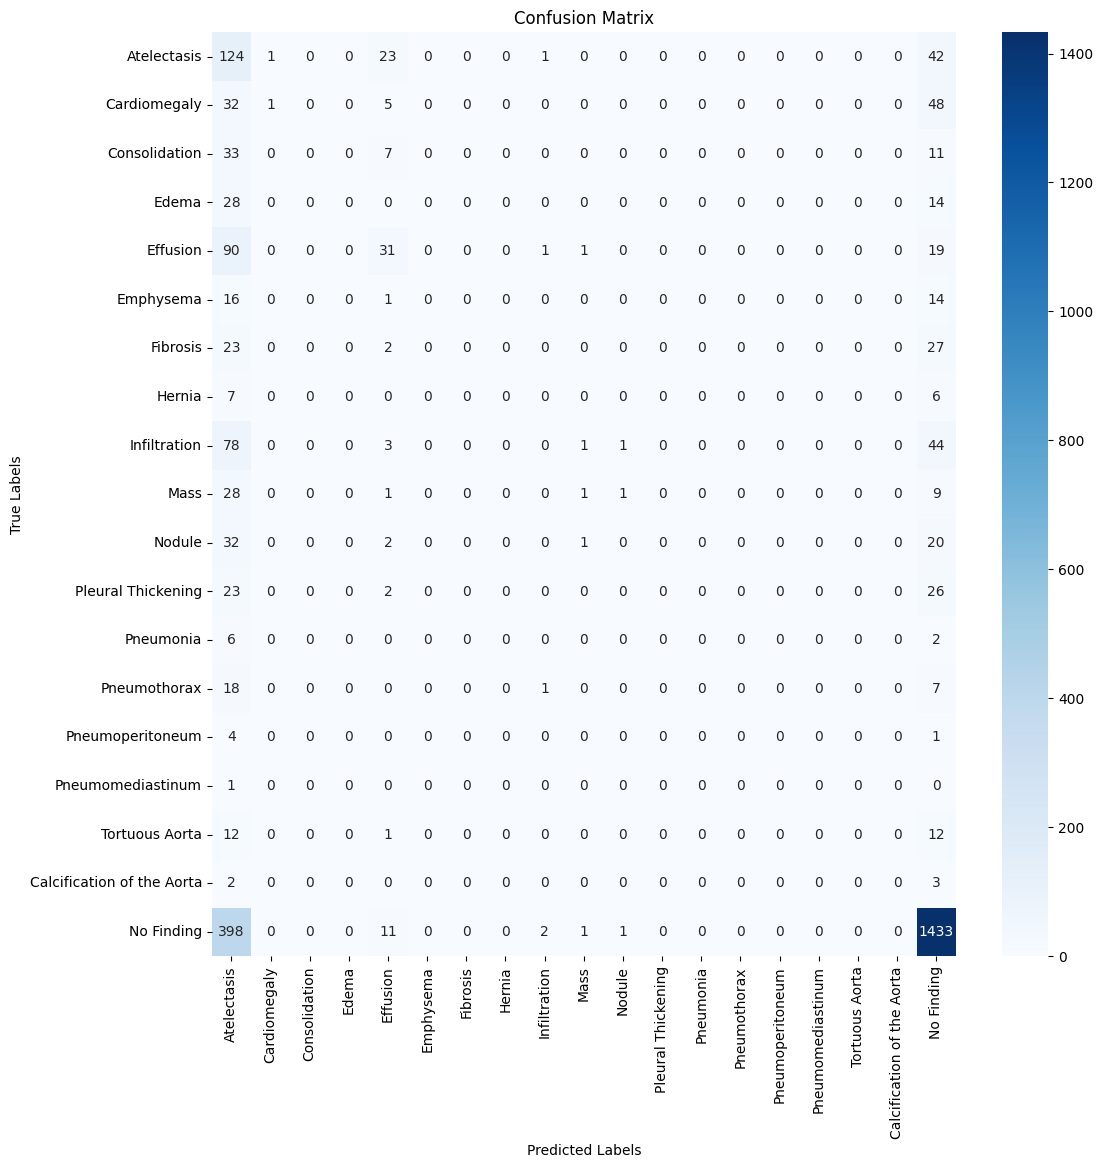

In [74]:
# Exclude the class that is not present in the true labels
class_names = list(label_map.keys())

true_labeled_classes = [class_names[i] for i in range(len(class_names)) if i != 16]

plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=true_labeled_classes, yticklabels=true_labeled_classes, cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

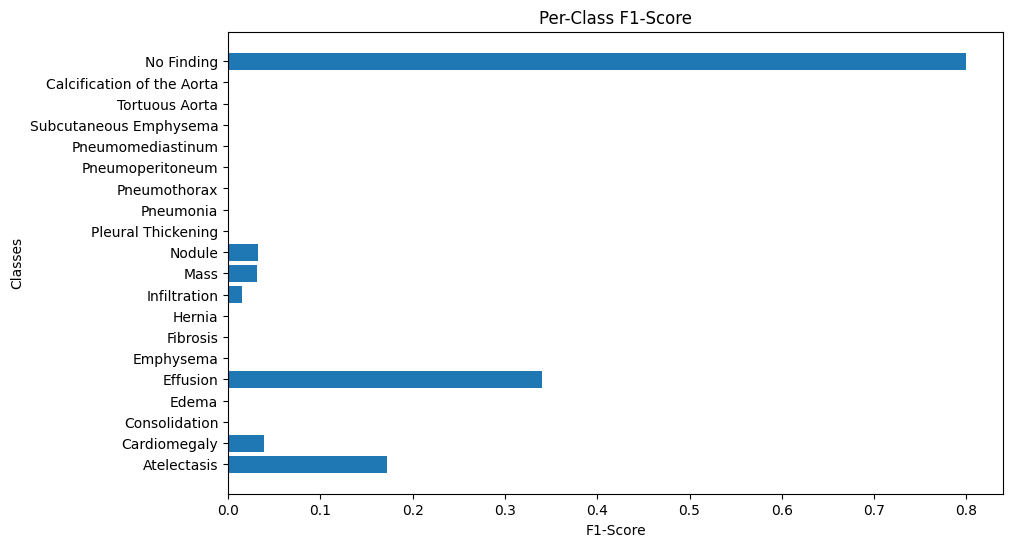

In [60]:
# Extract F1-scores for each class
f1_scores = report_df.loc[label_map.keys(), "f1-score"]

plt.figure(figsize=(10, 6))
plt.barh(list(label_map.keys()), f1_scores)
plt.xlabel("F1-Score")
plt.ylabel("Classes")
plt.title("Per-Class F1-Score")
plt.show()

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Flatten predictions and true labels
flat_predictions = all_predictions.flatten()
flat_true_labels = all_true_labels.flatten()

# Compute micro-averaged accuracy
micro_accuracy = accuracy_score(flat_true_labels, flat_predictions)

print(f"Micro-Averaged Accuracy: {micro_accuracy:.4f}")

# Compute micro-averaged precision and recall
micro_precision = precision_score(flat_true_labels, flat_predictions, average='micro')
micro_recall = recall_score(flat_true_labels, flat_predictions, average='micro')
micro_f1 = f1_score(flat_true_labels, flat_predictions, average='micro')

print(f"Micro-Averaged Precision: {micro_precision:.4f}")
print(f"Micro-Averaged Recall: {micro_recall:.4f}")
print(f"Micro F1-Score: {micro_f1:.4f}")

Micro-Averaged Accuracy: 0.9593
Micro-Averaged Precision: 0.9593
Micro-Averaged Recall: 0.9593
Micro F1-Score: 0.9593


In [78]:
# Macro-averaged metrics
macro_precision = precision_score(flat_true_labels, flat_predictions, average='macro')
macro_recall = recall_score(flat_true_labels, flat_predictions, average='macro')
macro_f1 = f1_score(flat_true_labels, flat_predictions, average='macro')

print(f"Macro Precision: {macro_precision:.4f}")
print(f"Macro Recall: {macro_recall:.4f}")
print(f"Macro F1-Score: {macro_f1:.4f}")

Macro Precision: 0.8866
Macro Recall: 0.7173
Macro F1-Score: 0.7748
